In [1]:
%cd ..

/home/alberto/PycharmProjects/incomplete_multiview_clustering


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
from time import perf_counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from imvc.datasets import LoadDataset
from imvc.ampute import Amputer
from imvc.cluster import DAIMC, IMSR, LFIMVC, EEIMVC, SIMCADC, NEMO

In [3]:
from tueplots import axes, bundles
plt.rcParams.update({**bundles.icml2022(), **axes.lines()})
for key in ["axes.labelsize", "axes.titlesize", "font.size", "legend.fontsize", "xtick.labelsize", "ytick.labelsize"]:
    if key == "legend.fontsize":
        plt.rcParams[key] += 4
    else:
        plt.rcParams[key] += 6

In [4]:
def dataset_engine_comp(results_dict, Xs, y, n_clusters, estimator, engines, ps, n_times, att_matrix):
    embeddings = False
    for p in tqdm(ps):
        missing_percentge = int(p*100)
        results_dict[missing_percentge] = {}
        matrices_comp = {}
        amputed_Xs = Amputer(p=p, mechanism="mcar", random_state=42).fit_transform(Xs)
        for engine in engines:
            results_dict[missing_percentge][engine] = {}
            matrices_comp[engine] = []
            for i in range(n_times):
                results_dict[missing_percentge][engine][i] = {}
                start_time = perf_counter()
                try:
                    model = estimator(n_clusters=n_clusters, engine=engine, random_state=i)
                    labels = model.fit_predict(amputed_Xs)
                except Exception as ex:
                    results_dict[missing_percentge][engine][i]["Comments"] = ex
                    continue
                results_dict[missing_percentge][engine][i]["Computing time"] = perf_counter() - start_time
                ami = adjusted_mutual_info_score(labels_true=y, labels_pred=labels)
                ari = adjusted_rand_score(labels_true=y, labels_pred=labels)
                results_dict[missing_percentge][engine][i]["Adjusted Mutual Information (AMI)"] = ami
                results_dict[missing_percentge][engine][i]["Adjusted Rand Index (ARI)"] = ari
                try:
                    embeddings = True
                    mat = getattr(model, att_matrix)
                    matrices_comp[engine].append(mat)
                except:
                    pass
                results_dict[missing_percentge][engine][i]["Comments"] = ""
        if embeddings:
            results_dict[missing_percentge]["both"] = {}
            results_dict[missing_percentge]["both"][0] = {}
            for engine in engines + ["both"]: 
                results_dict[missing_percentge][engine][0]["Root Mean Squared Error (RMSE)"] = []
                results_dict[missing_percentge][engine][0]["Mean Absolute Error (MAE)"] = []
                if engine == "both":
                    mats = [mat for mats in matrices_comp.values() for mat in mats]
                else:
                    mats = matrices_comp[engine]
                combs = set(itertools.combinations(range(len(mats)), 2))
                combs = [(mats[comb[0]], mats[comb[1]]) for comb in combs]
                for i, (mat1, mat2) in enumerate(combs):
                    rmse = mean_squared_error(y_true=mat1, y_pred=mat2, squared=False)
                    mae = mean_absolute_error(y_true=mat1, y_pred=mat2)
                    results_dict[missing_percentge][engine][0]["Root Mean Squared Error (RMSE)"].append(rmse)
                    results_dict[missing_percentge][engine][0]["Mean Absolute Error (MAE)"].append(mae)
    return results_dict

In [5]:
def engine_comp(datasets, estimator, engines, ps, n_times, att_matrix):
    results = {}
    for dataset in tqdm(datasets):
        names = dataset.split("_")
        if "simulated" in names:
            names = ["_".join(names)]
        x_name,y_name = names if len(names) > 1 else (names[0], "0")
        Xs, y = LoadDataset.load_dataset(dataset_name=x_name, return_y=True)
        y = y[y_name]
        n_clusters = int(y.nunique())
        
        results[dataset] = {}
        results[dataset] = dataset_engine_comp(results_dict= results[dataset], Xs=Xs, y=y, n_clusters=n_clusters,
                                               estimator=estimator, engines=engines, ps=ps, n_times=n_times,
                                               att_matrix=att_matrix)

    return results

In [6]:
def process_results(results, estimator_name, values_to_replace):
    flattened_data = [
    {
        'Dataset': dataset,
        'Incomplete samples (\%)': p,
        'Engine': engine,
        'Iteration': i,
        **iter_dict
    }
    for dataset, dataset_dict in results.items()
    for p, p_dict in dataset_dict.items()
    for engine, engine_dict in p_dict.items()
    for i, iter_dict in engine_dict.items()
]
    results = pd.DataFrame(flattened_data)
    for col_name, replacing_dict in values_to_replace.items():
        results[col_name] = results[col_name].replace(replacing_dict)
    if estimator_name is not None:
        results.to_csv(f"tutorials/engine_comparison_{estimator_name}.csv", index= None)
    return results

In [7]:
def estimator_time_comp(results, estimator_name, language_comparison):
    results["Estimator"] = estimator_name
    results = results[results["Engine"] != "Both"]
    for engine in results["Engine"].unique():
        mask = (results["Engine"] == engine) & (results["Comments"].notnull())
        mask = results.loc[mask, ["Dataset", "Incomplete samples (\%)", "Iteration"]]
        mask = mask.set_index(["Dataset", "Incomplete samples (\%)", "Iteration"]).index
        mask = results.set_index(["Dataset", "Incomplete samples (\%)", "Iteration"]).drop(labels=mask)
        results = mask.reset_index()
    time_engine = results.drop(columns="Comments")
    assert time_engine["Adjusted Mutual Information (AMI)"].notnull().all()
    time_engine = time_engine.groupby(["Estimator", "Dataset", "Engine"], as_index=False)["Computing time"].mean()
    time_engine = time_engine.set_index(["Estimator", "Dataset"])
    time_engine = time_engine.pivot(columns="Engine")
    time_engine.columns = time_engine.columns.droplevel(0)
    time_engine.columns.name = None
    time_engine["Speed-up"] = time_engine[language_comparison.capitalize()] / time_engine["Python"]
    return time_engine

In [8]:
def time_comp(estimator_list):
    time_engine = [estimator_time_comp(results=pd.read_csv(f"tutorials/engine_comparison_{estimator_name}.csv"),
                                   language_comparison=language_comparison, estimator_name=estimator_name)
                   for (estimator_name, language_comparison, _) in estimator_list]
    time_engine = pd.concat(time_engine)
    time_engine = time_engine[['Python'] + [c for c in time_engine.columns if c not in ['Python', 'Speed-up']] + ['Speed-up']]
    time_engine = time_engine.groupby(["Estimator"]).agg(['mean', lambda x: (x.min().round(1), x.max().round(1))])
    time_engine = time_engine.round(1).sort_values(("Speed-up", "mean"), ascending=False)
    time_engine.columns = pd.MultiIndex.from_tuples(
        [(col1, 'Average' if col2 == 'mean' else '(Min, Max)' if col2 == '<lambda_0>' else col2)
         for col1, col2 in time_engine.columns]
    )
    return time_engine

In [114]:
def prepare_visualizations(results):
    results = results[results["Comments"].isna()]
    results = results.drop(columns="Comments")
    for metric in ["Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)"]:
        results.loc[results["Iteration"] == 0, metric] = results.loc[results["Iteration"] == 0, metric].apply(eval)

    stability_results = []
    for _, row in results[results["Iteration"] == 0].iterrows():
        for rmse, mae in zip(row["Root Mean Squared Error (RMSE)"], row["Mean Absolute Error (MAE)"]):
            stability_results.append([row["Dataset"], row["Engine"], row["Incomplete samples (\%)"], rmse, mae])

    stability_results = pd.DataFrame(stability_results,
                                     columns= ["Dataset", "Engine", "Incomplete samples (\%)",
                                               "Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)"])

    results = results.set_index(["Dataset", "Engine", "Incomplete samples (\%)"])
    results = results.drop(columns= ["Iteration", "Computing time", "Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)"])
    stability_results = stability_results.set_index(["Dataset", "Engine", "Incomplete samples (\%)"])
    results = results.join(stability_results, how="right").reset_index()
    results = results.melt(id_vars= ["Dataset", "Engine", "Incomplete samples (\%)"], var_name='Metric', value_name='Value')
    results = results.sort_values(["Dataset", "Engine", "Incomplete samples (\%)"], ascending=[True, False, True])
    results["Metric"] = results["Metric"].replace({
        "Adjusted Mutual Information (AMI)": "Adjusted Mutual Information",
        "Adjusted Rand Index (ARI)": "Adjusted Rand Index",
        "Root Mean Squared Error (RMSE)": "Root Mean Squared Error",
        "Mean Absolute Error (MAE)": "Mean Absolute Error",
    })
    return results

In [138]:
estimator_list = [
    ("EEIMVC", "matlab", "embedding_"),
    ("SIMCADC", "matlab", "embedding_"),
    ("LFIMVC", "matlab", "embedding_"),
    ("NEMO", "r", "affinity_matrix_"),
    ("IMSR", "matlab", "embedding_"),
    ("DAIMC", "matlab", "embedding_"),
]

datasets = [
    "nutrimouse_genotype",
    "sensIT300",
    "buaa",
    "bbcsport",
    "bdgp"
]

In [11]:
for (estimator_name, language_comparison, att_matrix) in estimator_list:
    results = engine_comp(datasets= datasets,
                          estimator=eval(estimator_name), engines= ["python", language_comparison],
                          ps= np.arange(0., 0.7, 0.2), n_times = 50, att_matrix=att_matrix)
    results = process_results(results=results, estimator_name=estimator_name, values_to_replace={
        "Engine": {"python": "Python", "matlab": "Matlab", "r": "R", "both": "Both"},
        "Dataset": {"bbcsport": "BBCsport", "bdgp": "BDGP", "buaa": "BUAA", "nutrimouse_genotype": "Nutrimouse"},
    })
#    results = pd.concat([pd.read_csv(f"tutorials/engine_comparison_{estimator_name}.csv"), results])
#    results.to_csv(f"tutorials/engine_comparison_{estimator_name}.csv", index= None)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

    eigs at line 298 column 20
    update_F at line 9 column 11
    IMSC at line 18 column 9
    _pyeval at line 57 column 30

    update_X at line 9 column 19
    IMSC at line 22 column 9
    _pyeval at line 57 column 30

    update_X at line 9 column 19
    IMSC at line 22 column 9
    _pyeval at line 57 column 30

    eigs at line 298 column 20
    update_F at line 9 column 11
    IMSC at line 18 column 9
    _pyeval at line 57 column 30

    update_X at line 9 column 19
    IMSC at line 22 column 9
    _pyeval at line 57 column 30

    update_X at line 9 column 19
    IMSC at line 22 column 9
    _pyeval at line 57 column 30

    eigs at line 298 column 20
    update_F at line 9 column 11
    IMSC at line 18 column 9
    _pyeval at line 57 column 30

    update_X at line 9 column 19
    IMSC at line 22 column 9
    _pyeval at line 57 column 30

    update_X at line 9 column 19
    IMSC at line 22 column 9
    _pyeval at line 57 column 30

    eigs at line 298 column 20
    update_F

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [139]:
time_engine = time_comp(estimator_list=estimator_list)
time_engine

Python                Matlab                    R               
          Average    (Min, Max) Average   (Min, Max) Average  (Min, Max)   
Estimator                                                                  
LFIMVC        0.3    (0.0, 0.7)     0.9   (0.5, 1.5)     NaN  (nan, nan)  \
EEIMVC        0.2    (0.0, 0.9)     0.8   (0.5, 1.7)     NaN  (nan, nan)   
SIMCADC       1.0    (0.1, 3.3)     2.5   (0.6, 7.9)     NaN  (nan, nan)   
IMSR          2.6   (0.1, 11.3)     3.5  (0.6, 13.7)     NaN  (nan, nan)   
NEMO          2.7   (0.0, 12.3)     NaN   (nan, nan)     2.2  (0.0, 9.9)   
DAIMC        41.2  (0.7, 159.4)    19.6  (0.7, 67.4)     NaN  (nan, nan)   

          Speed-up               
           Average   (Min, Max)  
Estimator                        
LFIMVC        11.5  (1.7, 26.1)  
EEIMVC         9.9  (1.9, 27.1)  
SIMCADC        4.8   (1.3, 8.7)  
IMSR           2.6   (1.2, 4.9)  
NEMO           1.5   (0.4, 2.8)  
DAIMC          0.6   (0.4, 1.0)

In [115]:
estimator_name = "NEMO"
language_comparison = [i[1] for i in estimator_list if i[0] == estimator_name][0]
results = pd.read_csv(f"tutorials/engine_comparison_{estimator_name}.csv")
print(results.shape)
results.head()

(2020, 10)


,Dataset,Incomplete samples (\%),Engine,Iteration,Computing time,Adjusted Mutual Information (AMI),Adjusted Rand Index (ARI),Comments,Root Mean Squared Error (RMSE),Mean Absolute Error (MAE)
0,Nutrimouse,0,Python,0,0.179079,1.0,1.0,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Nutrimouse,0,Python,1,0.163057,1.0,1.0,NaN,NaN,NaN
2,Nutrimouse,0,Python,2,0.025313,1.0,1.0,NaN,NaN,NaN
3,Nutrimouse,0,Python,3,0.026137,1.0,1.0,NaN,NaN,NaN
4,Nutrimouse,0,Python,4,0.023290,1.0,1.0,NaN,NaN,NaN


In [116]:
estimator_time_comp(results.copy(), estimator_name, language_comparison)

Python         R  Speed-up
Estimator Dataset                                  
NEMO      BBCsport     0.448015  0.836841  1.867887
          BDGP        12.257654  9.865592  0.804852
          BUAA         0.029828  0.082862  2.777964
          Nutrimouse   0.023753  0.039233  1.651705
          sensIT300    0.699857  0.257812  0.368378

In [117]:
errors = results[results["Comments"].notnull()]
print("errors", errors.shape)
errors

errors (0, 10)


,Dataset,Incomplete samples (\%),Engine,Iteration,Computing time,Adjusted Mutual Information (AMI),Adjusted Rand Index (ARI),Comments,Root Mean Squared Error (RMSE),Mean Absolute Error (MAE)


In [118]:
errors[["Engine", "Comments"]].value_counts()

Series([], Name: count, dtype: int64)

In [119]:
results = prepare_visualizations(results=results)

In [120]:
# axes = sns.FacetGrid(data=results, row="Metric", col= "Dataset", dropna=True, legend_out=False,
#                      sharey=False, despine=False).map_dataframe(
#     sns.boxplot, x="Incomplete samples (\%)", y= "Value", hue= "Engine", palette= "colorblind",
#     hue_order=["Python", language_comparison.capitalize(), "Both"], showmeans=True,
#     meanprops={'markerfacecolor':'white', 'markeredgecolor':'black'})
# axes.add_legend()
# for ax, ylabel in zip(axes.axes[:, 0], results["Metric"].unique()):
#     ax.set_ylabel(ylabel)
# for ax in axes.axes.flatten():
#     if ("AMI" in ax.get_title()) or ("ARI" in ax.get_title()):
#         ax.set_ylim(-0.05, 1.05)
#     ax.set_title("")
# for ax, title in zip(axes.axes[0, :], results["Dataset"].unique()):
#     ax.set_title(title)
# for i in range(results["Metric"].nunique()):   
#     for j in range(1, results["Dataset"].nunique()):   
#         axes.axes[i,j].get_yaxis().set_visible(False)
    
# plt.tight_layout()
# plt.savefig(f"engine_comparison_{estimator_name}.pdf")

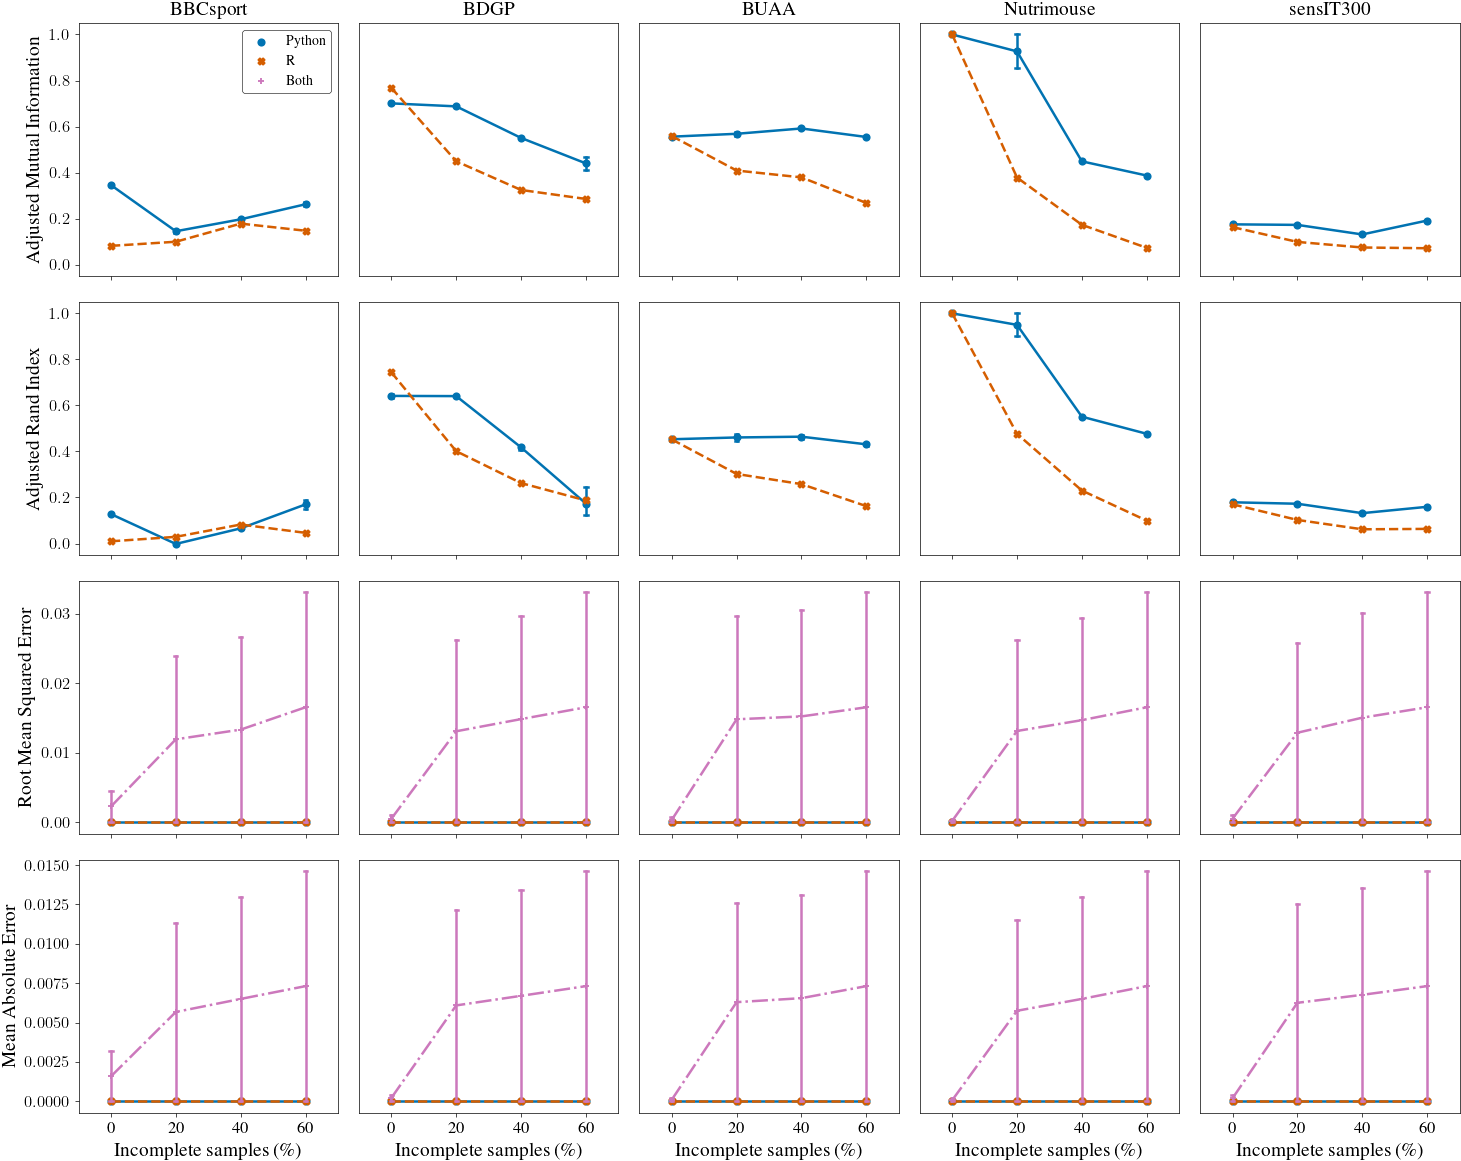

In [121]:
colorblind_palette = sns.color_palette("colorblind")
color_language_idx = 1 if language_comparison == "matlab" else 3
axes = sns.FacetGrid(data=results.drop_duplicates(), row="Metric", col= "Dataset", dropna=True, legend_out=False,
                     sharey=False, despine=False).map_dataframe(
    sns.pointplot, x="Incomplete samples (\%)", y= "Value", hue= "Engine",
    palette= [colorblind_palette[0]] + [colorblind_palette[color_language_idx]] + [colorblind_palette[4]],
    hue_order=["Python", language_comparison.capitalize(), "Both"], linestyles= ["-", "--", "-."],
    markers= ["o", "X", "+"], capsize= 0.05, seed= 42)
axes.add_legend()
for ax, ylabel in zip(axes.axes[:, 0], results["Metric"].unique()):
    ax.set_ylabel(ylabel)
for ax in axes.axes.flatten():
    if "Adjusted" in ax.get_title():
        ax.set_ylim(-0.05, 1.05)
    ax.set_title("")
for ax, title in zip(axes.axes[0, :], results["Dataset"].unique()):
    ax.set_title(title)
for i in range(results["Metric"].nunique()):   
    for j in range(1, results["Dataset"].nunique()):   
        axes.axes[i,j].get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.savefig(f"engine_comparison_{estimator_name}.pdf")

In [135]:
estimator_list = [
#    ("EEIMVC", "matlab", "embedding_"),
#    ("SIMCADC", "matlab", "embedding_"),
    ("LFIMVC", "matlab", "embedding_"),
    ("NEMO", "r", "affinity_matrix_"),
    ("IMSR", "matlab", "embedding_"),
#    ("DAIMC", "matlab", "embedding_"),
]
total_results = []
for (estimator_name, language_comparison, _) in estimator_list:
    results = pd.read_csv(f"tutorials/engine_comparison_{estimator_name}.csv")
    results = prepare_visualizations(results=results)
    results["Algorithm"] = estimator_name
    if estimator_name == "NEMO":
        results = results.sort_values("Engine", ascending=True)
    total_results.append(results[(results["Metric"] == "Adjusted Mutual Information") & (results["Engine"] != "Both")])
total_results = pd.concat(total_results)
total_results["Split"] = total_results["Algorithm"] + total_results["Engine"]
total_results.head()

,Dataset,Engine,Incomplete samples (\%),Metric,Value,Algorithm,Split
264800,BBCsport,Python,0,Adjusted Mutual Information,0.435341,LFIMVC,LFIMVCPython
264801,BBCsport,Python,0,Adjusted Mutual Information,0.464080,LFIMVC,LFIMVCPython
264802,BBCsport,Python,0,Adjusted Mutual Information,0.406862,LFIMVC,LFIMVCPython
264803,BBCsport,Python,0,Adjusted Mutual Information,0.537327,LFIMVC,LFIMVCPython
264804,BBCsport,Python,0,Adjusted Mutual Information,0.496461,LFIMVC,LFIMVCPython


In [136]:
colorblind_palette = sns.color_palette("colorblind")
n_estimators = total_results["Algorithm"].unique()
estimator_colors_dict = {estimator:colorblind_palette[i] 
                         for i, estimator in enumerate(n_estimators)}
estimator_colors_dict = {mix: col for mix in total_results["Split"]
                         for est, col in estimator_colors_dict.items() if mix.startswith(est)}
estimator_markers_dict = {estimator:["o", "+", "x", "*", "1", "2"][i]
                          for i, estimator in enumerate(n_estimators)}
estimator_markers_dict = {mix: col for mix in total_results["Split"]
                          for est, col in estimator_markers_dict.items() if mix.startswith(est)}
engine_linestyles_dict = {"Python": "-", "Matlab": "--", "R": "-."}
engine_linestyles_dict = {mix: col for mix in total_results["Split"] 
                          for eng, col in engine_linestyles_dict.items() if mix.endswith(eng)}

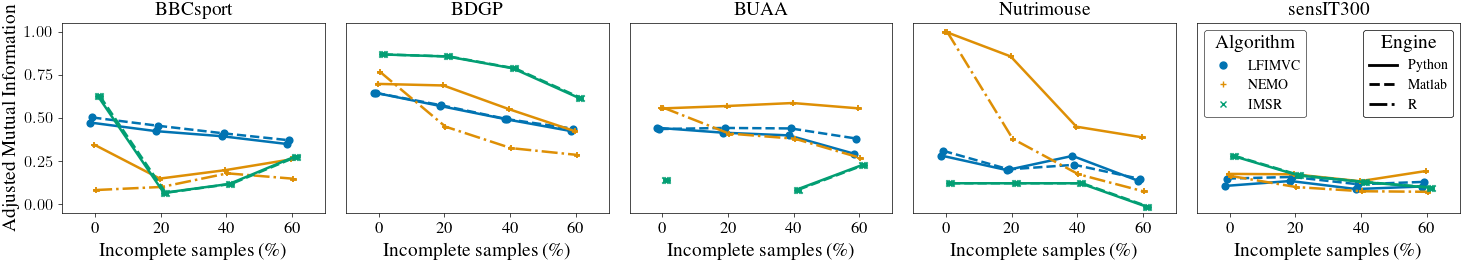

In [137]:
g = sns.FacetGrid(data=total_results, col= "Dataset", col_wrap=5, dropna=True, legend_out=False,
                     sharey=False, despine=False, ylim=(-0.05, 1.05)).map_dataframe(
    sns.pointplot, x="Incomplete samples (\%)", y= "Value", hue= "Split", dodge=True,
    palette= estimator_colors_dict, linestyles= list(engine_linestyles_dict.values()),
    markers=list(estimator_markers_dict.values()), capsize= 0.05, seed= 42)

ax_legend = g.axes.flatten()[-1]
handles = [plt.Line2D([0], [0], marker=marker, color=col, lw=0, markersize=5, markerfacecolor=col)
           for i, (_, col, marker) in enumerate(
               zip(n_estimators, colorblind_palette, ["o", "+", "x", "*", "1", "2"]))]
new_legend = ax_legend.legend(handles=handles,
                              labels=n_estimators.tolist(),
                              title="Algorithm", loc="upper left")
ax_legend.add_artist(new_legend)
handles = [plt.Line2D([0], [0], color='black', lw=2, linestyle=linestyle)
           for linestyle in np.unique(list(engine_linestyles_dict.values()))]
new_legend = ax_legend.legend(handles=handles, 
                              labels=total_results["Engine"].unique().tolist(),
                              title="Engine", loc="upper right")
ax_legend.add_artist(new_legend)

for ax, ylabel in zip(g.axes, total_results["Metric"].unique()):
    ax.set_ylabel(ylabel)
for ax, title in zip(g.axes, total_results["Dataset"].unique()):
    ax.set_title(title)
for i in range(1, total_results["Dataset"].nunique()): 
    g.axes[i].get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.savefig(f"engine_comparison_joint.pdf")